In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [2]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_18188\876263972.py:2: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")


In [3]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [4]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [5]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


## Dugon arnon

In [139]:

def get_segments(labels):
    """Return list of (start_idx, end_idx, label) for continuous segments"""
    segments = []
    start = 0
    current_label = labels[0]

    for i in range(1, len(labels)):
        if labels[i] != current_label:
            segments.append((start, i, current_label))
            start = i
            current_label = labels[i]

    segments.append((start, len(labels), current_label))
    return segments
segments = get_segments(labels)

valid_segments = [seg for seg in segments if (seg[1] - seg[0]) >= 256]
seg_df = pd.DataFrame(valid_segments, columns=['start', 'end', 'Annotation'])
seg_df["length"] = seg_df["end"] - seg_df["start"]






In [140]:
seg_df

,start,end,Annotation,length
0,0,61440,Sleep stage W,61440
1,61440,122880,Sleep stage N1,61440
2,122880,130560,Sleep stage N2,7680
3,130560,138240,Sleep stage N1,7680
4,138240,184320,Sleep stage N2,46080
...,...,...,...,...
94,5967360,5982720,Sleep stage N1,15360
95,5982720,6120960,Sleep stage W,138240
96,6120960,6159360,Sleep stage N1,38400
97,6159360,6481920,Sleep stage N2,322560


In [141]:
seg_df_n3 = seg_df[seg_df['Annotation'] == ' Sleep stage N3']
print(seg_df_n3)



      start      end       Annotation  length
15   806400   821760   Sleep stage N3   15360
17   829440   844800   Sleep stage N3   15360
19   852480   898560   Sleep stage N3   46080
21   906240   921600   Sleep stage N3   15360
23   929280   936960   Sleep stage N3    7680
64  3571200  3609600   Sleep stage N3   38400
76  4945920  4976640   Sleep stage N3   30720
78  4984320  4992000   Sleep stage N3    7680


In [142]:
seg_df_R = seg_df[seg_df['Annotation'] == ' Sleep stage R']
print(seg_df_R)

      start      end      Annotation  length
31  1190400  1328640   Sleep stage R  138240
33  1336320  1382400   Sleep stage R   46080
49  2403840  2411520   Sleep stage R    7680
51  2419200  2426880   Sleep stage R    7680
70  3978240  4193280   Sleep stage R  215040
72  4200960  4416000   Sleep stage R  215040
83  5299200  5306880   Sleep stage R    7680
85  5345280  5790720   Sleep stage R  445440


In [143]:
seg_df_W = seg_df[seg_df['Annotation'] == ' Sleep stage W']
print(seg_df_W)

      start      end      Annotation  length
0         0    61440   Sleep stage W   61440
6    199680   207360   Sleep stage W    7680
10   268800   299520   Sleep stage W   30720
34  1382400  1474560   Sleep stage W   92160
40  1896960  1904640   Sleep stage W    7680
53  2434560  3079680   Sleep stage W  645120
55  3087360  3095040   Sleep stage W    7680
57  3102720  3118080   Sleep stage W   15360
73  4416000  4454400   Sleep stage W   38400
80  5007360  5030400   Sleep stage W   23040
87  5798400  5806080   Sleep stage W    7680
93  5959680  5967360   Sleep stage W    7680
95  5982720  6120960   Sleep stage W  138240
98  6481920  6558720   Sleep stage W   76800


In [144]:
seg_df_W = seg_df[seg_df['Annotation'] == ' Sleep stage N1']
print(seg_df_W)

      start      end       Annotation  length
1     61440   122880   Sleep stage N1   61440
3    130560   138240   Sleep stage N1    7680
5    184320   199680   Sleep stage N1   15360
7    207360   253440   Sleep stage N1   46080
9    261120   268800   Sleep stage N1    7680
11   299520   391680   Sleep stage N1   92160
13   629760   637440   Sleep stage N1    7680
25  1075200  1082880   Sleep stage N1    7680
27  1136640  1144320   Sleep stage N1    7680
29  1175040  1182720   Sleep stage N1    7680
32  1328640  1336320   Sleep stage N1    7680
35  1474560  1520640   Sleep stage N1   46080
37  1551360  1566720   Sleep stage N1   15360
39  1843200  1896960   Sleep stage N1   53760
41  1904640  1943040   Sleep stage N1   38400
43  2127360  2135040   Sleep stage N1    7680
45  2211840  2219520   Sleep stage N1    7680
47  2304000  2311680   Sleep stage N1    7680
52  2426880  2434560   Sleep stage N1    7680
54  3079680  3087360   Sleep stage N1    7680
56  3095040  3102720   Sleep stage

In [145]:
seg_df_N2 = seg_df[seg_df['Annotation'] == ' Sleep stage N2']
print(seg_df_N2)

      start      end       Annotation  length
2    122880   130560   Sleep stage N2    7680
4    138240   184320   Sleep stage N2   46080
8    253440   261120   Sleep stage N2    7680
12   391680   629760   Sleep stage N2  238080
14   637440   806400   Sleep stage N2  168960
16   821760   829440   Sleep stage N2    7680
18   844800   852480   Sleep stage N2    7680
20   898560   906240   Sleep stage N2    7680
22   921600   929280   Sleep stage N2    7680
24   936960  1075200   Sleep stage N2  138240
26  1082880  1136640   Sleep stage N2   53760
28  1144320  1175040   Sleep stage N2   30720
30  1182720  1190400   Sleep stage N2    7680
36  1520640  1551360   Sleep stage N2   30720
38  1566720  1843200   Sleep stage N2  276480
42  1943040  2127360   Sleep stage N2  184320
44  2135040  2211840   Sleep stage N2   76800
46  2219520  2304000   Sleep stage N2   84480
48  2311680  2403840   Sleep stage N2   92160
50  2411520  2419200   Sleep stage N2    7680
59  3179520  3287040   Sleep stage

In [146]:
seg_counts = seg_df['Annotation'].value_counts()
print(seg_counts)



Annotation
Sleep stage N1    36
Sleep stage N2    33
Sleep stage W     14
Sleep stage N3     8
Sleep stage R      8
Name: count, dtype: int64


## Select data

### train set 

In [221]:
##ตัวนี้มีน้อย เอาตัวนี้เป็นเบส
# selected_n3_train = seg_df[
#     (
#         ((seg_df['start'] >= 806400) & (seg_df['end'] <= 821760)) |
#         ((seg_df['start'] >= 829440) & (seg_df['end'] <= 844800)) |
#         ((seg_df['start'] >= 852480) & (seg_df['end'] <= 898560)) |
#         ((seg_df['start'] >= 906240) & (seg_df['end'] <= 921600))
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N3')
# ]
selected_n3_train = seg_df.loc[[15, 17, 19, 21]]


In [222]:
# selected_r_train = seg_df[
#     (
#         ((seg_df['start'] >= 3978240) & (seg_df['end'] <= 4070400)) #70
#     )
#     & (seg_df['Annotation'] == ' Sleep stage R')
# ]
# ดึง row ที่ index = 31
r_seg = seg_df.loc[31]

# ตัดเฉพาะ 92160 sample แรกของช่วงนี้
partial_r_seg = pd.DataFrame([{
    'start': r_seg['start'],
    'end': r_seg['start'] + 92160,
    'Annotation': r_seg['Annotation'],
    'length': 92160
}])
selected_r_train = pd.concat([partial_r_seg], ignore_index=True)




In [223]:
selected_r_train

,start,end,Annotation,length
0,1190400,1282560,Sleep stage R,92160


In [224]:
# selected_w_train = seg_df[
#     (
#         ((seg_df['start'] >= 1382400) & (seg_df['end'] <= 1474560)) 
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage W')
# ]
selected_w_train = seg_df.loc[[34]]


In [225]:
# selected_n1_train = seg_df[
#     (
#         ((seg_df['start'] >= 299520) & (seg_df['end'] <= 391680)) 
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N1')
# ]
selected_n1_train = seg_df.loc[[11]]


In [226]:
# selected_n2_train = seg_df[
#     (
#         ((seg_df['start'] >= 2311680) & (seg_df['end'] <= 2403840)) 
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N2')
# ]
selected_n2_train = seg_df.loc[[48]]

In [227]:
for name, df in {
    "N1": selected_n1_train,
    "N2": selected_n2_train,
    "N3": selected_n3_train,
    "R": selected_r_train,
    "W": selected_w_train
}.items():
    print(f"{name}: {len(df)} segments")


N1: 1 segments
N2: 1 segments
N3: 4 segments
R: 1 segments
W: 1 segments


### Test set

In [228]:
##ตัวนี้มีน้อย เอาตัวนี้เป็นเบส
# selected_n3_test = seg_df[
#     (
#         ((seg_df['start'] >= 929280) & (seg_df['end'] <= 936960)) |
#         ((seg_df['start'] >= 3571200) & (seg_df['end'] <= 3609600)) 
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N3')
# ]
selected_n3_test = seg_df.loc[[23,64]]

In [229]:
# selected_r_test = seg_df[
#     (
#         ((seg_df['start'] >= 1336320) & (seg_df['end'] <= 1382400)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage R')
# ]
selected_r_test = seg_df.loc[[33]]

In [230]:
# selected_w_test = seg_df[
#     (
#         ((seg_df['start'] >= 0) & (seg_df['end'] <= 46080)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage W')
# ]
w_seg_test = seg_df.loc[0]

# ตัดเฉพาะ 92160 sample แรกของช่วงนี้
partial_w_seg = pd.DataFrame([{
    'start': w_seg_test['start'],
    'end': w_seg_test['start'] + 46080,
    'Annotation': w_seg_test['Annotation'],
    'length': 92160
}])
selected_w_test = pd.concat([partial_w_seg], ignore_index=True)

In [231]:
# selected_n1_test = seg_df[
#     (
#         ((seg_df['start'] >= 1474560) & (seg_df['end'] <= 41520640)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N1')
# ]
selected_n1_test = seg_df.loc[[35]]

In [232]:
# selected_n2_test = seg_df[
#     (
#         ((seg_df['start'] >= 138240) & (seg_df['end'] <= 184320)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N2')
# ]
selected_n2_test = seg_df.loc[[4]]

In [233]:
for name, df in {
    "N1": selected_n1_test,
    "N2": selected_n2_test,
    "N3": selected_n3_test,
    "R": selected_r_test,
    "W": selected_w_test
}.items():
    print(f"{name}: {len(df)} segments")


N1: 1 segments
N2: 1 segments
N3: 2 segments
R: 1 segments
W: 1 segments


### Validate set

In [244]:
##ตัวนี้มีน้อย เอาตัวนี้เป็นเบส
# selected_n3_val = seg_df[
#     (
#         ((seg_df['start'] >= 4945920) & (seg_df['end'] <= 4976640)) |
#         ((seg_df['start'] >= 4984320) & (seg_df['end'] <= 4992000)) 
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N3')
# ]
selected_n3_val = seg_df.loc[[76,78]]

In [245]:
# selected_r_val = seg_df[
#     (
#         ((seg_df['start'] >= 5345280) & (seg_df['end'] <= 5383680)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage R')
# ]
r_seg_val = seg_df.loc[85]

# ตัดเฉพาะ 92160 sample แรกของช่วงนี้
partial_r_segval = pd.DataFrame([{
    'start': r_seg_val['start'],
    'end': r_seg_val['start'] + 38400,
    'Annotation': r_seg_val['Annotation'],
    'length': 92160
}])
selected_r_val = pd.concat([partial_r_segval], ignore_index=True)

In [246]:
# selected_w_val = seg_df[
#     (
#         ((seg_df['start'] >= 4416000) & (seg_df['end'] <= 4454400)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage W')
# ]
selected_w_val = seg_df.loc[[73]]

In [247]:
# selected_n1_val = seg_df[
#     (
#         ((seg_df['start'] >= 1904640) & (seg_df['end'] <= 1943040)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N1')
# ]
selected_n1_val = seg_df.loc[[41]]

In [248]:
# selected_n2_val = seg_df[
#     (
#         ((seg_df['start'] >= 5859840) & (seg_df['end'] <= 5898240)) 
         
        
#     )
#     & (seg_df['Annotation'] == ' Sleep stage N2')
# ]
n2_seg_val = seg_df.loc[89]

# ตัดเฉพาะ 92160 sample แรกของช่วงนี้
partial_n2_segval = pd.DataFrame([{
    'start': n2_seg_val['start'],
    'end': n2_seg_val['start'] + 38400,
    'Annotation': n2_seg_val['Annotation'],
    'length': 92160
}])
selected_n2_val = pd.concat([partial_n2_segval], ignore_index=True)

In [249]:
for name, df in {
    "N1": selected_n1_val,
    "N2": selected_n2_val,
    "N3": selected_n3_val,
    "R": selected_r_val,
    "W": selected_w_val
}.items():
    print(f"{name}: {len(df)} segments")


N1: 1 segments
N2: 1 segments
N3: 2 segments
R: 1 segments
W: 1 segments


### Train/Test/Val Slit

In [250]:
# รวม segment ของ train/test/val แต่ละคลาส
train_segments = pd.concat([
    selected_n3_train,
    selected_r_train,
    selected_w_train,
    selected_n1_train,
    selected_n2_train
], ignore_index=True)

test_segments = pd.concat([
    selected_n3_test,
    selected_r_test,
    selected_w_test,
    selected_n1_test,
    selected_n2_test
], ignore_index=True)

val_segments = pd.concat([
    selected_n3_val,
    selected_r_val,
    selected_w_val,
    selected_n1_val,
    selected_n2_val
], ignore_index=True)


In [268]:
train_segments

,start,end,Annotation,length
0,806400,821760,Sleep stage N3,15360
1,829440,844800,Sleep stage N3,15360
2,852480,898560,Sleep stage N3,46080
3,906240,921600,Sleep stage N3,15360
4,1190400,1282560,Sleep stage R,92160
5,1382400,1474560,Sleep stage W,92160
6,299520,391680,Sleep stage N1,92160
7,2311680,2403840,Sleep stage N2,92160


In [269]:
test_segments

,start,end,Annotation,length
0,929280,936960,Sleep stage N3,7680
1,3571200,3609600,Sleep stage N3,38400
2,1336320,1382400,Sleep stage R,46080
3,0,46080,Sleep stage W,92160
4,1474560,1520640,Sleep stage N1,46080
5,138240,184320,Sleep stage N2,46080


In [270]:
val_segments

,start,end,Annotation,length
0,4945920,4976640,Sleep stage N3,30720
1,4984320,4992000,Sleep stage N3,7680
2,5345280,5383680,Sleep stage R,92160
3,4416000,4454400,Sleep stage W,38400
4,1904640,1943040,Sleep stage N1,38400
5,5859840,5898240,Sleep stage N2,92160


In [251]:
X_train_df = pd.concat([data.iloc[row.start:row.end] for _, row in train_segments.iterrows()])
y_train_df = pd.concat([labels.iloc[row.start:row.end] for _, row in train_segments.iterrows()])

X_test_df = pd.concat([data.iloc[row.start:row.end] for _, row in test_segments.iterrows()])
y_test_df = pd.concat([labels.iloc[row.start:row.end] for _, row in test_segments.iterrows()])

X_val_df = pd.concat([data.iloc[row.start:row.end] for _, row in val_segments.iterrows()])
y_val_df = pd.concat([labels.iloc[row.start:row.end] for _, row in val_segments.iterrows()])



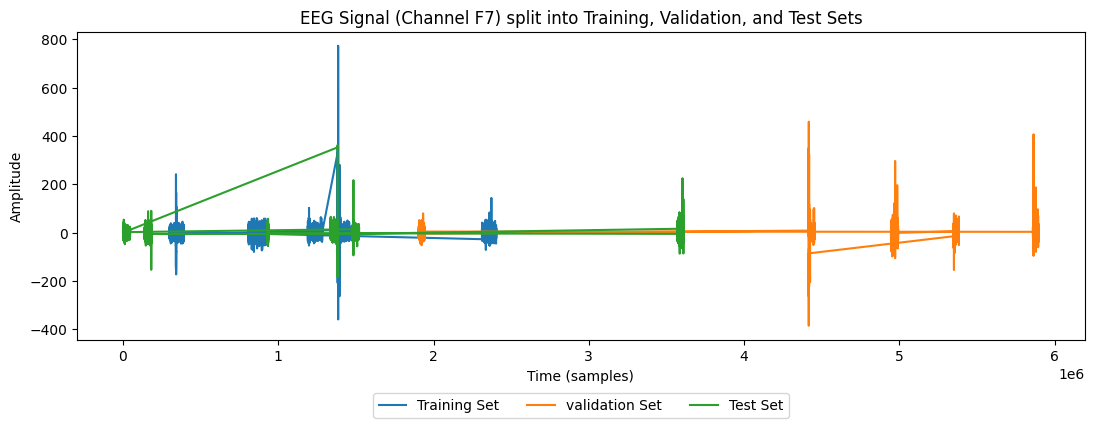

In [277]:
plt.figure(figsize=(13, 4))
plt.plot(X_train_df['EEG F4-M1'], label='Training Set')
plt.plot(X_val_df['EEG F4-M1'], label='validation Set')
plt.plot(X_test_df['EEG F4-M1'], label='Test Set')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("EEG Signal (Channel F7) split into Training, Validation, and Test Sets")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.show()

In [252]:
print("Train class distribution (%):")
print(y_train_df.value_counts(normalize=True) * 100)

print("\nTest class distribution (%):")
print(y_test_df.value_counts(normalize=True) * 100)

print("\nValidation class distribution (%):")
print(y_val_df.value_counts(normalize=True) * 100)

Train class distribution (%):
Annotation
Sleep stage N3    20.0
Sleep stage R     20.0
Sleep stage W     20.0
Sleep stage N1    20.0
Sleep stage N2    20.0
Name: proportion, dtype: float64

Test class distribution (%):
Annotation
Sleep stage N3    20.0
Sleep stage R     20.0
Sleep stage W     20.0
Sleep stage N1    20.0
Sleep stage N2    20.0
Name: proportion, dtype: float64

Validation class distribution (%):
Annotation
Sleep stage N3    20.0
Sleep stage R     20.0
Sleep stage W     20.0
Sleep stage N1    20.0
Sleep stage N2    20.0
Name: proportion, dtype: float64


In [253]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N3    92160
 Sleep stage R     92160
 Sleep stage W     92160
 Sleep stage N1    92160
 Sleep stage N2    92160
 Name: count, dtype: int64,
 Annotation
 Sleep stage N3    38400
 Sleep stage R     38400
 Sleep stage W     38400
 Sleep stage N1    38400
 Sleep stage N2    38400
 Name: count, dtype: int64,
 Annotation
 Sleep stage N3    46080
 Sleep stage R     46080
 Sleep stage W     46080
 Sleep stage N1    46080
 Sleep stage N2    46080
 Name: count, dtype: int64)

### Select Channel

In [255]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460800 entries, 806400 to 2403839
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   EEG F4-M1  460800 non-null  float64
 1   EEG C4-M1  460800 non-null  float64
 2   EEG O2-M1  460800 non-null  float64
 3   EEG C3-M2  460800 non-null  float64
 4   EMG chin   460800 non-null  float64
 5   EOG E1-M2  460800 non-null  float64
 6   EOG E2-M2  460800 non-null  float64
 7   ECG        460800 non-null  float64
dtypes: float64(8)
memory usage: 31.6 MB


In [256]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1','EEG C3-M2']

# Create the new DataFrame with only the selected channels
X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced = X_val_df[selected_channels]
X_test_df_reduced = X_test_df[selected_channels]

X_train_df_reduced.shape, X_val_df_reduced.shape, X_test_df_reduced.shape

((460800, 4), (192000, 4), (230400, 4))

### Create Sliding Window

In [257]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานได้แน่นอน
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        # ตรวจว่าทั้ง window มี label เดียวกันไหม
        unique_labels = label_slice.unique()
        if len(unique_labels) == 1:  # ✅ มีคลาสเดียว
            window_data.append(window)
            window_label.append(unique_labels[0])
        else:
            continue  # 🚫 ถ้ามีมากกว่า 1 คลาส -> ข้ามเลย

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y



In [258]:
# Define parameters
window_size = 256
step_size = 128

# Apply sliding window function to the train/test set
X_train, y_train =  apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val =  apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

X_train: (3595, 256, 8) , y_train: (3595,)
X_val: (1495, 256, 8) , y_val: (1495,)
X_test: (1795, 256, 8) , y_test: (1795,)
X_train_reduced: (3595, 256, 4) , y_train_reduced: (3595,)
X_val_reduced: (1495, 256, 4) , y_val_reduced: (1495,)
X_test_reduced: (1795, 256, 4) , y_test_reduced: (1795,)


Sample (original y_train_df):
Annotation
Sleep stage N3    92160
Sleep stage R     92160
Sleep stage W     92160
Sleep stage N1    92160
Sleep stage N2    92160
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
Sleep stage N3    719
Sleep stage R     719
Sleep stage W     719
Sleep stage N1    719
Sleep stage N2    719
Name: count, dtype: int64
                N Sample
Annotation              
Sleep stage N3     92160
Sleep stage R      92160
Sleep stage W      92160
Sleep stage N1     92160
Sleep stage N2     92160


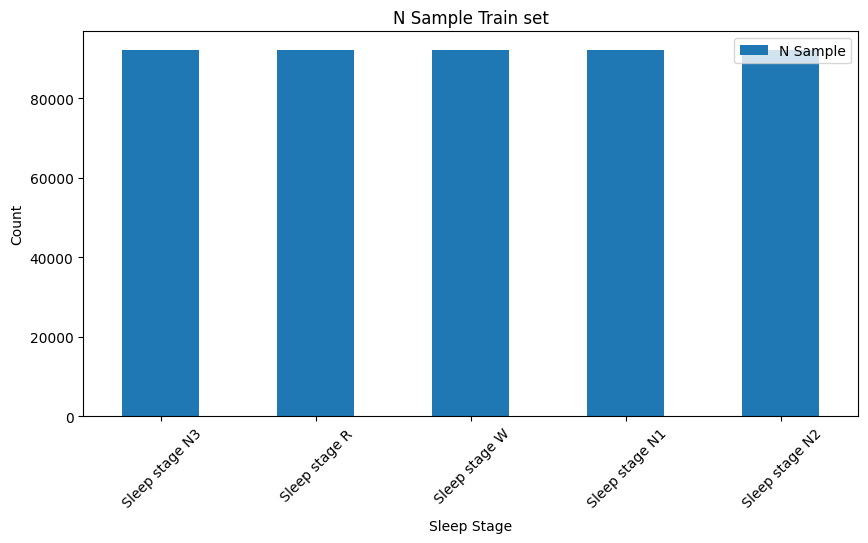

Annotation
Sleep stage N3    20.0
Sleep stage R     20.0
Sleep stage W     20.0
Sleep stage N1    20.0
Sleep stage N2    20.0
Name: proportion, dtype: float64


In [259]:
print("Sample (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "N Sample": y_train_df.value_counts(),
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("N Sample Train set")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()
print(y_train_df.value_counts(normalize=True) * 100)

In [260]:
def clean_X_y(X, y):
    """Remove samples where y is NaN or 'nan' string"""
    # ตัดให้ X, y มีความยาวเท่ากันก่อน
    min_len = min(len(X), len(y))
    X = X[:min_len]
    y = y[:min_len]

    mask = ~(pd.isna(y) | (y == 'nan'))
    X_clean = X[mask]
    y_clean = y[mask]
    return X_clean, y_clean

# --- ลบ NaN และทำให้ขนาดตรงกัน ---
X_train, y_train = clean_X_y(X_train, y_train)
X_val, y_val     = clean_X_y(X_val, y_val)
X_test, y_test   = clean_X_y(X_test, y_test)

print("Shapes after cleaning NaN:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes after cleaning NaN:
X_train: (3595, 256, 8) y_train: (3595,)
X_val: (1495, 256, 8) y_val: (1495,)
X_test: (1795, 256, 8) y_test: (1795,)


## Train

### CNN

In [261]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [262]:

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train_reduced, dtype=np.float32)
X_val   = np.array(X_val_reduced, dtype=np.float32)
X_test  = np.array(X_test_reduced, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

X_train shape: (3595, 256, 4)
y_train shape: (3595, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 250, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,189 (692.14 KB)

 Trainable params: 176,613 (689.89 KB)

 Non-trainable params: 576 (2.25 KB)

In [263]:
# --- Ensure all sets are same length ---
min_train_len = min(len(X_train), len(y_train_cat))
min_val_len   = min(len(X_val), len(y_val_cat))
min_test_len  = min(len(X_test), len(y_test_cat))

X_train = X_train[:min_train_len]
y_train_cat = y_train_cat[:min_train_len]

X_val = X_val[:min_val_len]
y_val_cat = y_val_cat[:min_val_len]

X_test = X_test[:min_test_len]
y_test_cat = y_test_cat[:min_test_len]

print("After sync:")
print("Train:", X_train.shape, y_train_cat.shape)
print("Val:  ", X_val.shape, y_val_cat.shape)
print("Test: ", X_test.shape, y_test_cat.shape)

After sync:
Train: (3595, 256, 4) (3595, 5)
Val:   (1495, 256, 4) (1495, 5)
Test:  (1795, 256, 4) (1795, 5)


In [274]:
# -----------------------------
# 4. Train CNN model (no early stopping)
# -----------------------------
callbacks = [
    ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=500,
    batch_size=32,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.1987 - val_loss: 29.8165
Epoch 2/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9975 - loss: 0.0140 - val_accuracy: 0.1987 - val_loss: 38.8001
Epoch 3/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.1920 - val_loss: 37.3955
Epoch 4/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.1900 - val_loss: 35.4535
Epoch 5/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.1819 - val_loss: 41.4762
Epoch 6/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9947 - loss: 0.0218 - val_accuracy: 0.3559 - val_loss: 19.9839
Epoch 7/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9919 - loss: 0.0317 - val_accuracy: 0.1926 - val_loss: 29.8156
Epoch 8/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9978 - loss: 0.

In [265]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2485 - loss: 16.2819
Test Loss: 16.2819, Test Accuracy: 24.85%


In [266]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


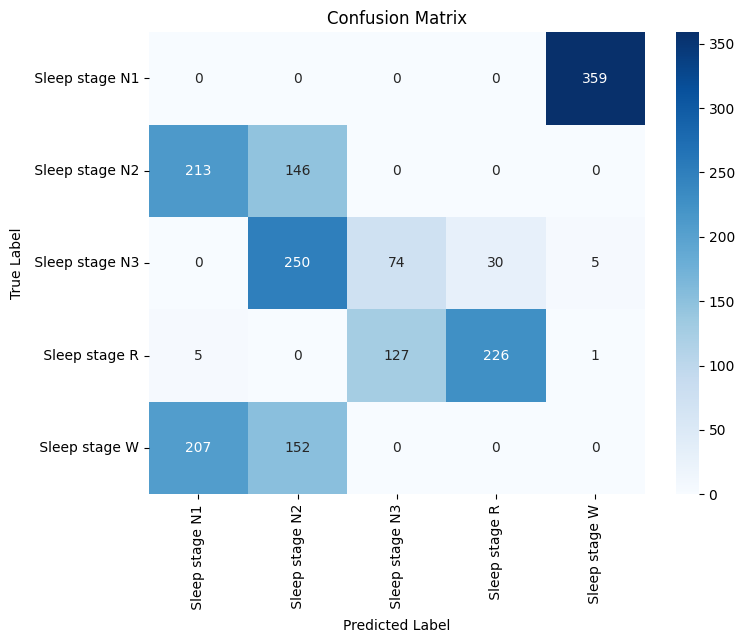

                 precision    recall  f1-score   support

 Sleep stage N1       0.00      0.00      0.00       359
 Sleep stage N2       0.27      0.41      0.32       359
 Sleep stage N3       0.37      0.21      0.26       359
  Sleep stage R       0.88      0.63      0.73       359
  Sleep stage W       0.00      0.00      0.00       359

       accuracy                           0.25      1795
      macro avg       0.30      0.25      0.26      1795
   weighted avg       0.30      0.25      0.26      1795



In [267]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

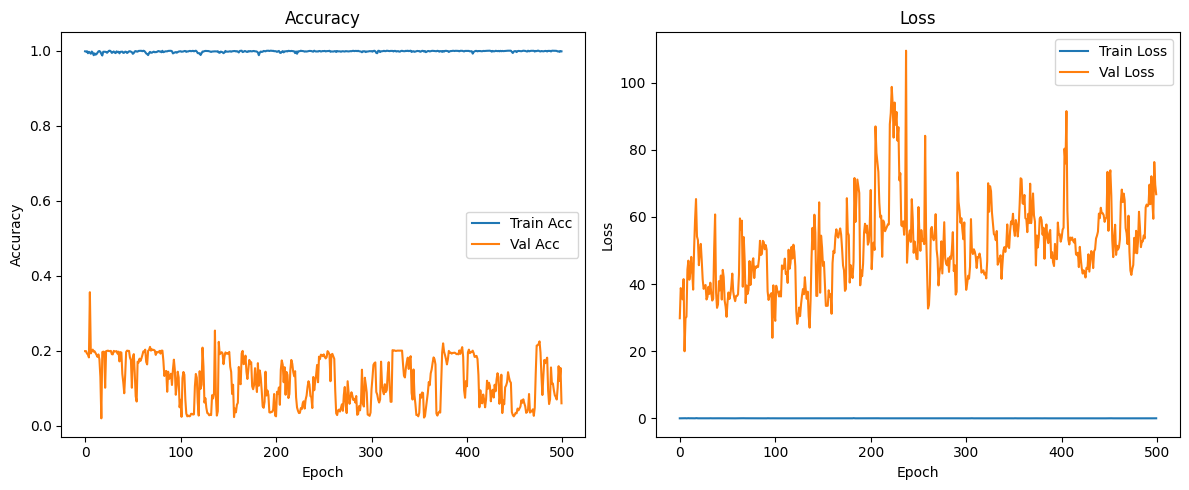

()

In [276]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
()

In [273]:
print("Train class distribution:")
print(y_train_df.value_counts(normalize=True))

print("\nVal class distribution:")
print(y_val_df.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test_df.value_counts(normalize=True))



Train class distribution:
Annotation
Sleep stage N3    0.2
Sleep stage R     0.2
Sleep stage W     0.2
Sleep stage N1    0.2
Sleep stage N2    0.2
Name: proportion, dtype: float64

Val class distribution:
Annotation
Sleep stage N3    0.2
Sleep stage R     0.2
Sleep stage W     0.2
Sleep stage N1    0.2
Sleep stage N2    0.2
Name: proportion, dtype: float64

Test class distribution:
Annotation
Sleep stage N3    0.2
Sleep stage R     0.2
Sleep stage W     0.2
Sleep stage N1    0.2
Sleep stage N2    0.2
Name: proportion, dtype: float64


## A

In [278]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

# ----------------------------------
# 🧹 1️⃣ ล้างช่องว่างซ้ายขวา + แปลงชื่อคลาสเป็นตัวเลข
# ----------------------------------
def clean_and_encode_labels(y):
    # แปลงเป็น string ทั้งหมดก่อน (เผื่อมีบางค่าเป็น int)
    y = pd.Series(y).astype(str).str.strip()
    
    label_map = {
        'Sleep stage N1': 0,
        'Sleep stage N2': 1,
        'Sleep stage N3': 2,
        'Sleep stage R': 3,
        'Sleep stage W': 4
    }
    
    # แปลงชื่อเป็นตัวเลข
    return y.replace(label_map).astype(int).values

# ใช้ฟังก์ชันกับทุกชุด
y_train_clean = clean_and_encode_labels(y_train)
y_val_clean   = clean_and_encode_labels(y_val)
y_test_clean  = clean_and_encode_labels(y_test)

print("✅ Unique y_train_clean:", np.unique(y_train_clean))
print("✅ Unique y_val_clean:", np.unique(y_val_clean))
print("✅ Unique y_test_clean:", np.unique(y_test_clean))

# ----------------------------------
# 2️⃣ แปลงเป็น one-hot
# ----------------------------------
num_classes = 5
y_train_cat = to_categorical(y_train_clean, num_classes)
y_val_cat   = to_categorical(y_val_clean, num_classes)
y_test_cat  = to_categorical(y_test_clean, num_classes)

# -----------------------------
# 🎯 เลือกเฉพาะ 1 channel ก่อนเข้า CNN
# -----------------------------
target_channel = "EEG F4-M1"

# กรณีข้อมูลหลัง sliding window เป็น numpy array
# เช่น X_train_reduced.shape = (samples, 256, 4)
channel_names = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']

# หา index ของ channel เป้าหมาย
ch_idx = channel_names.index(target_channel)

# ตัดเฉพาะช่องที่ต้องการ (เหลือเพียง 1 channel)
X_train = X_train_reduced[:, :, ch_idx:ch_idx+1]
X_val   = X_val_reduced[:, :, ch_idx:ch_idx+1]
X_test  = X_test_reduced[:, :, ch_idx:ch_idx+1]

print("✅ ใช้เฉพาะ channel:", target_channel)
print("X_train shape:", X_train.shape)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

✅ Unique y_train_clean: [0 1 2 3 4]
✅ Unique y_val_clean: [0 1 2 3 4]
✅ Unique y_test_clean: [0 1 2 3 4]
✅ ใช้เฉพาะ channel: EEG F4-M1
X_train shape: (3595, 256, 1)
X_train shape: (3595, 256, 1)
y_train shape: (3595, 5)


C:\Users\HP\AppData\Local\Temp\ipykernel_18188\14186043.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return y.replace(label_map).astype(int).values
C:\Users\HP\AppData\Local\Temp\ipykernel_18188\14186043.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return y.replace(label_map).astype(int).values
C:\Users\HP\AppData\Local\Temp\ipykernel_18188\14186043.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 250, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,517 (689.52 KB)

 Trainable params: 175,941 (687.27 KB)

 Non-trainable params: 576 (2.25 KB)

In [279]:
print("✅ Unique y_train_clean:", np.unique(y_train_clean))
print("✅ Unique y_val_clean:", np.unique(y_val_clean))
print("✅ Unique y_test_clean:", np.unique(y_test_clean))
print("✅ num_classes:", num_classes)
print(type(y_train_clean[0]), type(y_val_clean[0]), type(y_test_clean[0]))


✅ Unique y_train_clean: [0 1 2 3 4]
✅ Unique y_val_clean: [0 1 2 3 4]
✅ Unique y_test_clean: [0 1 2 3 4]
✅ num_classes: 5
<class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'>


In [280]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3864 - loss: 1.6303 - val_accuracy: 0.2642 - val_loss: 2.2684
Epoch 2/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5349 - loss: 1.1000 - val_accuracy: 0.2114 - val_loss: 6.7874
Epoch 3/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5828 - loss: 1.0089 - val_accuracy: 0.1973 - val_loss: 9.4496
Epoch 4/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6225 - loss: 0.8804 - val_accuracy: 0.1993 - val_loss: 15.0161
Epoch 5/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6682 - loss: 0.8181 - val_accuracy: 0.2033 - val_loss: 11.1731
Epoch 6/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6804 - loss: 0.7871 - val_accuracy: 0.2000 - val_loss: 16.0812
Epoch 7/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7076 - loss: 0.7225 - val_accuracy: 0.2000 - val_loss: 19.6128
Epoch 8/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7318 - loss: 0.6506 - val_

In [281]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3292 - loss: 10.0482
Test Loss: 10.0482, Test Accuracy: 32.92%


In [282]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


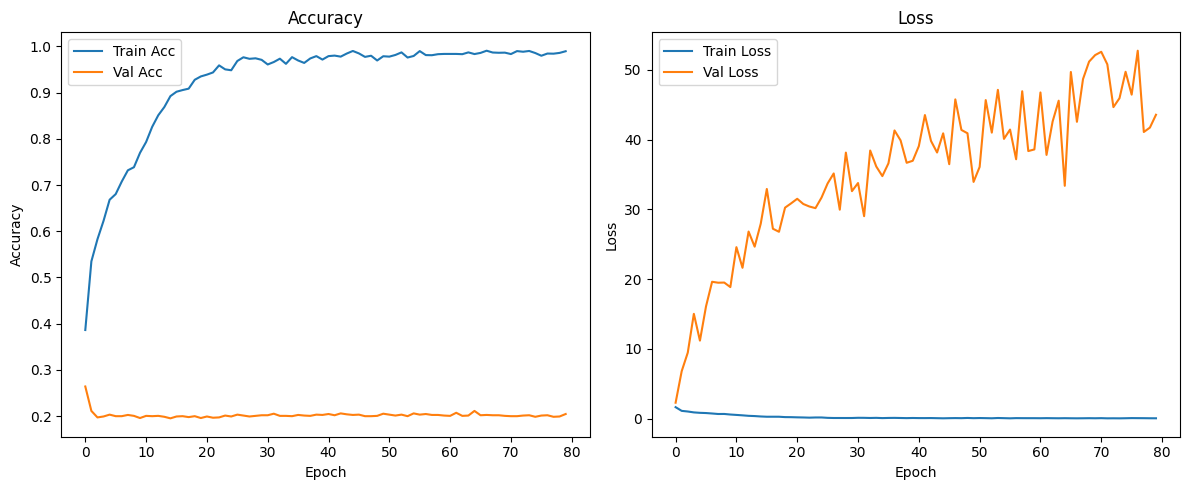

()

In [283]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
()

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


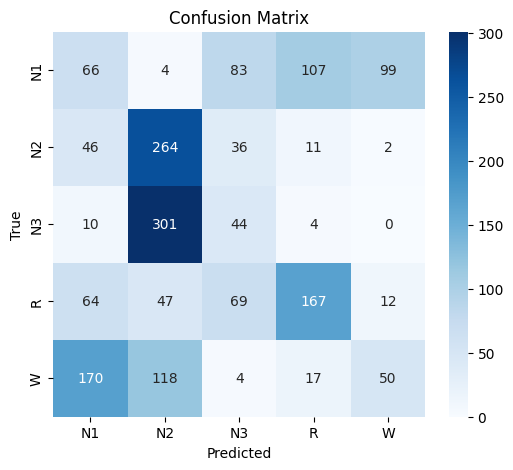

              precision    recall  f1-score   support

          N1       0.19      0.18      0.18       359
          N2       0.36      0.74      0.48       359
          N3       0.19      0.12      0.15       359
           R       0.55      0.47      0.50       359
           W       0.31      0.14      0.19       359

    accuracy                           0.33      1795
   macro avg       0.32      0.33      0.30      1795
weighted avg       0.32      0.33      0.30      1795



In [284]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['N1','N2','N3','R','W'],
            yticklabels=['N1','N2','N3','R','W'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['N1','N2','N3','R','W']))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


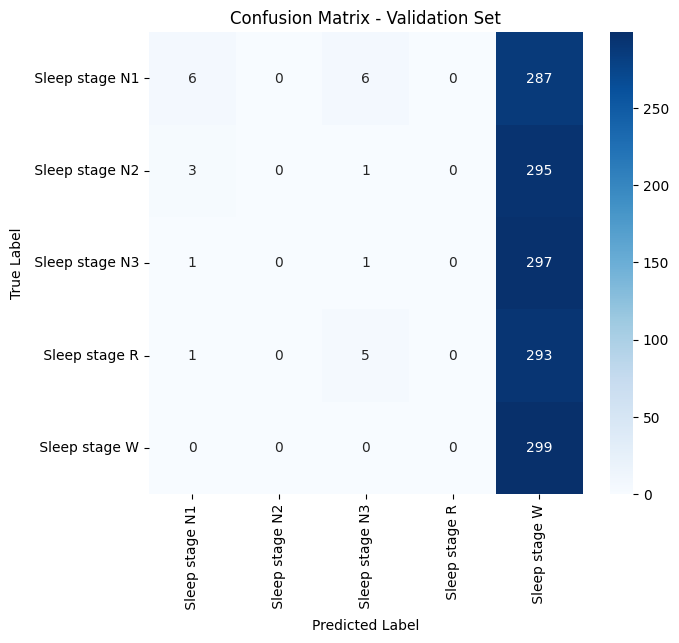

Validation Accuracy: 0.2047


In [285]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---- พยากรณ์บน validation set ----
y_val_pred_prob = model_cnn.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val_cat, axis=1)

# ---- คำนวณ confusion matrix ----
cm_val = confusion_matrix(y_val_true, y_val_pred)
labels = encoder.classes_

# ---- แสดง confusion matrix ----
plt.figure(figsize=(7,6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# ---- แสดง accuracy เพิ่มเติม ----
val_acc = np.mean(y_val_pred == y_val_true)
print(f"Validation Accuracy: {val_acc:.4f}")
